# Hands-On ML: Chapter 3, Classification

For this chapter, we'll be using the "Hello World" of machine learning-- the MNIST dataset which contains 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. 

Summary

1. Basic binary classifier for images
2. Performance measures for classification (E.g. Recall, Precision --- ROC Curve)
3. Multi-Class, Multi-Label, Multi-Output Classification
4. Error Analysis

In [2]:
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


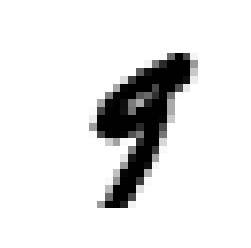

In [4]:
#There are 70,000 images and each image has 784 features. This is because each image is
# 28x28 pixels, and each feature simply repersents one pixel's intensity, from 0 (white) to
# 255 (black). We can check out one digit from the dataset:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation = "nearest")

plt.axis("off")
plt.show()

In [5]:
y[36000] # check the label

'9'

In [6]:
#create the test and training set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#Shuffle the data to ensure 1) Each CV fold will be similar 2)Some algos are sensitive to the order of the training
#instances; they will perform poorly if there are too many similar instances in a row.
import numpy as np
shuffle_index = np.random.permutation(60000)

## Training a Binary Classifier

In [7]:
#Lets build a simple binary classifier for 5 or not 5
y_train_5 = (y_train == '5') #this will create a y-label that is False for not 5 and True for 5
y_test_5 = (y_test == '5')
y_train_5

array([ True, False, False, ...,  True, False, False])

In [8]:
#Lets choose a classifier and see
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
#This is our number 9 example from above
sgd_clf.predict([some_digit])

array([False])

## Performance Measures

In [10]:
#In practice, we'll often encounter situations where we need more control over the CV process
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42) #3 splits

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #create a fresh clone of the SGD classifier we specified
    X_train_folds = X_train[train_index] #set the current k-1 folds of training data
    y_train_folds = (y_train_5[train_index]) #set the current k-1 folds of training labels
    X_test_fold = X_train[test_index] #set the current kth fold of test data
    y_test_fold = (y_train_5[test_index]) #set the current kth fold of test labels
    
    clone_clf.fit(X_train_folds, y_train_folds) #fit the classifier on the training data
    y_pred = clone_clf.predict(X_test_fold) #predict on test data
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) #calculate % correct

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.9532


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.95125


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.9625


In [14]:
#Is our 95% classifier good?
#Lets try a base estimator that always estimate Not-5
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return(np.zeros((len(X), 1), dtype = bool)) #everything zero

In [16]:
#Lets see the accuracy of this naive classifier
#Its still pretty high! We 
from sklearn.model_selection import cross_val_score
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

In [17]:
#Confusion Matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

#The rows are actual classes
#The columns are predicted classes
# TP FP
# FN TN

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

array([[52992,  1587],
       [ 1074,  4347]])

There are other metrics that are more concise

**precision = TP / (TP + FP)**
Think of it as true positives per positive actual

**recall = TP / (TP + FN)**
Think of it as true positives per positive prediction

You can conveniently combine precision and recall into a single metric called the F1 score. The F1 score is the *harmonic mean* of precision and recall. The idea is that the F1 score puts more weight to low values--> large values will have very small 1/value, and contribute less to the mean. This is good for things like average speed, where a sudden jolt can increase your average speed, but thats not reflective of how fast you were really driving in NY. Likewise, we don't want a super high recall or precision to mask low value in the other. **Huge caveat**: F1 favours classifiers that have similar precision and recall, but that's not always the goal. E.g. a classifier that detects videos safe for kids. You will settle for a low precision (it predicts a lot of good videos as bad) but demand high recall (of the good predicts, many of them are truly good).

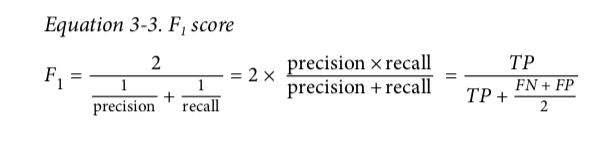

In [26]:
from IPython.display import Image
Image(filename='./images/f1_score_equation.png') 

In [24]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) #only 73% of the predictions are accurate
print(recall_score(y_train_5, y_train_pred)) #and 80% of the 5s are predicted

0.7325581395348837
0.8018815716657444


In [28]:
#Precision/Recall Tradeoff

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

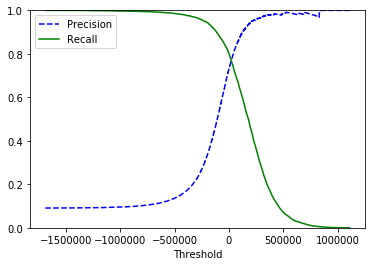

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[: -1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[: -1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

The classifier scores a value for whether a digit is 5 or not. The precision_recall_curve function will provide the precisions and recalls for different threshold of 5 or not on the score. It simply ingests the scores (y_scores) and the actual label (y_train_5) and stores the decisions across thresholds. As you can see, there is a clear tradeoff. When the threshold is low, the classifier predicts a lot of digits as 5's and scores a high recall; the true positive per positive prediction is high if you're predicting everything positive. When the threshold is high, the classifier predicts very few digits as 5's and scores a high precision; it only predicts positive when it is very sure and scores a high positive prediction per actual positive.

## ROC Curve

The classic! The receiver operating characteristic curve is probably the most common tool for binary classifiers. It plots true positive rate (recall) against false positive rate. The false positive rate is:

FPR = FP / (FP + TN)

It is the rate of incorrect positive predictions over total negative actuals. It is also 1 - TNR. TNR is the true negative rate = TN / (TN + FP). The TNR is also called specificity. Hence, the ROCI is often described as **sensitivity** (recall) vs **1 - specificity**

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

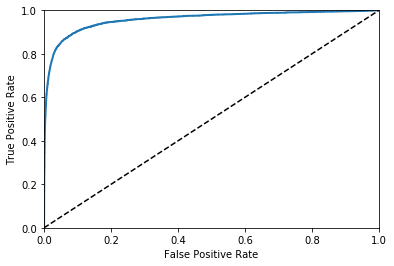

In [37]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9584692857783504

In [41]:
#Lets compare SGDClassifier vs RandomForestClassifier
#The random forest will generate prediction probabilities, not scores. 
#A simple solution is to just use that probability as the score. Since we're looking at ratios, it doesn't matter
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                   method = 'predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


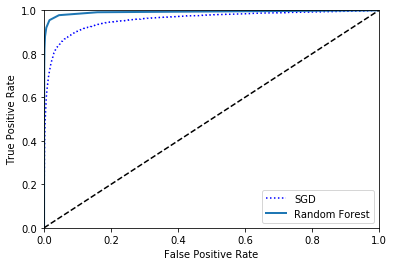

In [44]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

# Multiclass Classification

While some algos like Random Forest and Naive Bayes can naturally handle multiple classes, others like SVM and linear classifiers are strictly binary. Lets look at some strategies to implement binary classifiers to multinomial class problems.

1) One-Versus-All (OvA) strategy. Build a binary classifier for each class, and pick the class that output the higest score.

2) One-Versus-One (OvO) strategy. Build a binary classifier for every pair of classes. If there are N classes, you will need to train N x (N -1 )/2 classifiers. The advantage for this strategy is that each classifier can be trained quicker since you will only need data from the pair. Algos like SVM scale poorly with the size of the training set, so OvO is a faster way to train them. OvA is generally preferred.

In [45]:
#sklearn will automatically select OvA if it detects you are trying to implement
sgd_clf.fit(X_train, y_train) #not y_train_5 here
sgd_clf.predict([some_digit]) #it makes 1 prediction here, but under the hood, it trained for 10 digits

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array(['9'], dtype='<U1')

In [46]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-846573.96783425, -334136.90477277, -461748.96543531,
        -197470.29859882,  -94954.78149796, -219741.10518294,
        -846748.06720991, -298928.89337382, -563099.41054912,
          13625.40971728]])

In [55]:
#forcing sklearn to do OvO
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter = 6, random_state = 42))
ovo_clf.fit(X_train, y_train)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19.

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=6,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [58]:
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

['4']
45


In [59]:
#Random Forecast can directly handle multinominal classes without OvO or OvA
forest_clf.fit(X_train, y_train) #again, not y_train_5 but all the classes
forest_clf.predict([some_digit])

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array(['9'], dtype=object)

In [60]:
#Lets go back to the SGD example
#The cross val score on this is not bad
print(cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy"))
#But its even better if we standardize the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

[0.86872625 0.87639382 0.87848177]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

[0.90736853 0.90884544 0.91363705]


## Error Analysis

After going through the process of data preparation, creating a shortlist of models, fine tuning them and choosing the best one, this section is about understanding the errors and how to further improve the model.

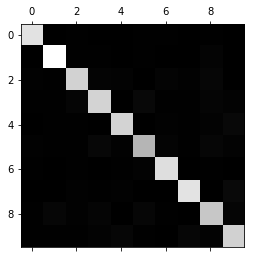

In [65]:
#Confusion matrix like before, but for multiple classes
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

#The lighter the grey, the higher the count. So this is pretty good from a high level, most of the digits are correctly classified
#and there aren't too many false positives. But some are a digits are slightly grey.

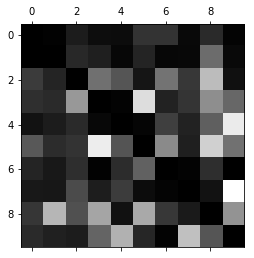

In [66]:
#However, we're not really that interested in absolute number of errors, we rather examine the rate
row_sums = conf_mx.sum(axis = 1, keepdims = True) #remember rows is actuals, this is the actual count for the digits
norm_conf_mx = conf_mx / row_sums #divide each count of prediction by its actual

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

#The rate = predicted count/actual count. A high rate means we over predict (many FP). A low rate means we under predict (many FN).
#Column 8,9 are relatively bright, which means we often misclassify digits as 8 or 9
#This plot tells us we should focus on improving our classification fo 8 and 9
#this could be more feature engineering, e.g. a preprocessing algo focused on idetnifying closed loops

## Multilabel Classification

So far, we have only dealt with problems that assign one class to one instance. But there are cases where we want our classifier to output multiple classes for each instance. For example, if we are doing facial recognition to identify users, multiple users can be in the same photo. We need to build a classifier that outputs multiple binary labels (Alice 1/0, Bill 1/0 etc.)-- this is called a multilabel classification system.

In [74]:
from sklearn.neighbors import KNeighborsClassifier

y_train2 = y_train.astype(np.int) 

y_train_large = (y_train2 >= 7) #labels for any digit greater than or equal to 7--> binary 1/0
y_train_odd = (y_train2 % 2 == 1) #labels for any digit that is odd --> binary 1/0
y_multilabel = np.c_[y_train_large, y_train_odd] #create a two label combination [1/0 greater than 7, 1/0 odd digit]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [75]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [76]:
knn_clf.predict([some_digit]) #thats correct, 9 is large and 9 is odd

array([[ True,  True]])

In [78]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv = 3)
f1_score(y_train, y_train_knn_pred, average = "weighted") #weighted by number of times the instance e.g. odd appears in training set

NameError: name 'f1_score' is not defined

## Multioutput Classification

The last type of classification task we are going to discuss here is called multioutput/multiclass classification. Instead of binary classes, the labels can be more than 2 classes. Here, we'll try and builder a classifier to remove noise from images. It will predict the intensity/darkless of each pixel as with classes 0 to 255. **Note** the line between classification and regression can get blurry-- we can easily frame the problem such that the class labels are value labels, like regression. But not recommended.

In [ ]:
noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod  = X_test